# Inaugural Project

> **Note the following:** 
> 1. This is an example of how to structure your **inaugural project**.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `inauguralproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [2]:
import numpy as np
import scipy
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm 
plt.style.use('seaborn-whitegrid')
import time

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import inauguralproject

# Question 1

We answer question 1 in two ways: First by using scipy optimize to find optimal utility and next by defining our own algorithm that loops through all possibilities to find optimal utility.

#### Defining initial functions
Here we define the utility function that we aim to maximize as well as the budget constraint and the equilibrium condition.

In [3]:
def u(c, l):
    """ utility function, calculates utility given consumption and labor supply
    
    Args:
    
        c (float): consumption
        l (float): labor supply
        
    Returns:
        (float): utility
    """
    return np.log(c) - v * l **(1+1/eps) / (1+1/eps)

def optimal_consumption(l,m,w,t_0,t_1,k):
    """ budget constraint, calculates optimal consumption given labor supply, wage and parameters
    
    Args:
    
        l (float): labor supply
        w (float): wage
    Returns:
        (float): optimal consumption
    """
    
    return m + w*l - (t_0 * w * l + t_1 * max(w * l - k, 0))

def equilibrium(l,v,eps,m,w,t_0,t_1,k):
    """ calculates optimal consumption and resulting utility given labor supply, wage and parameters
    
    Args:
     
        l (float): labor supply
        w (float): wage
        
    Returns:
        (float): negative utility
    """
    
    c = optimal_consumption(l,m,w,t_0,t_1,k)
    return -u(c, l)


Here we use the scipy optimize function to solve the labor supply problem for a wage of 1.

In [4]:
start = time.time()

# a. set parameters
m = 1     # float, cash-on-hand
v = 10    # float, scaling of disutility of labor supply
w = 1     # float, wage
eps = 0.3 # float, Frisch elasticity of labor supply
t_0 = 0.4 # float, standard labor income tax
t_1 = 0.1 # float, top bracket labor income tax
k = 0.4   # float, cut-off for the top labor income bracket 

# b. find optimal labor supply and consumption 
res = optimize.minimize_scalar(equilibrium,bounds=(0,1),args=(v,eps,m,w,t_0,t_1,k), method = "bounded")
l_star = res.x
c_star = optimal_consumption(l_star,m,w, t_0, t_1, k)

# c. print results
print(f'Optimal labour supply: {l_star:.2f}')
print(f'Optimal consumption: {c_star:.2f}')
print(f'Utility: {u(c_star, l_star):.2f}')

end = time.time()
print(f'Time elapsed: {end - start:.10f} seconds')

Optimal labour supply: 0.40
Optimal consumption: 1.24
Utility: 0.17
Time elapsed: 0.0019953251 seconds


#### Manual optimization

Here we define the optimization algorithm manually by looping through possibilities. We initialize by guessing of c=l=0. Then we loop through all possibilites of c and l (subject to the constraint) and save the combination of c and l that maximizes utility. 

In [5]:
def f(w, N=1000, do_print=True):
    """ calculates optimal labor supply, consumption and resulting utility given wage and parameters
    
    Args:
    
        w (float): wage
        N (int): default = 1000, number of iterations in loop
        do_print (bool): default = True, prints result
        
    Returns:
        c_best (float): optimal consumption choice
        l_best (float): optimal labor supply choice
        u_best (float): optimal utility given optimal consumption and labor
        c_values (tuple): all values of consumption calculated in loop
        l_values (tuple): all values of labor supply used in loop
        u_values (tuple): all values of utility calculated in loop
    """
    # a. allocate numpy arrays
    shape_tuple = (N)
    c_values = np.empty(shape_tuple)
    l_values = np.empty(shape_tuple)
    u_values = np.empty(shape_tuple)
    
    # b. start from guess of c=l=0
    c_best = 0
    l_best = 0
    u_best = u(0,0)
    
    # c. loop through all possibilities
    for i in range(N):
        
        # i. l must be between 0 and 1
        l_values[i] = l = i/N
        
        # ii. implied c
        c_values[i] = c = m + w*l - (t_0 * w * l + t_1 * max(w * l - k, 0))
            
        # iii. utility    
        u_values[i] = u(c,l)
        
        if u_values[i] >= u_best:    
            c_best = c_values[i]
            l_best = l_values[i] 
            u_best = u_values[i]
            
    # d. print
    if do_print:
        print(f'Optimal labour supply: {l_best:.2f}')
        print(f'Optimal consumption: {c_best:.2f}')
        print(f'Utility: {u(c_best, l_best):.2f}')

    return c_best,l_best,u_best,c_values,l_values,u_values

We call the function for a wage of 1 and get the same result as before.

In [6]:
start = time.time()

m = 1
v = 10
eps = 0.3
t_0 = 0.4
t_1 = 0.1
k = 0.4

solve = f(w=1)

end = time.time()
print(f'Time elapsed: {end - start:.10f} seconds')

Optimal labour supply: 0.40
Optimal consumption: 1.24
Utility: 0.17
Time elapsed: 0.0040042400 seconds


C:\Users\Mathilde Bechmann\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


We find that both ways of solving the problem returns the correct result, however scipy optimize is faster, why we will use this function in the rest of the assignment.

# Question 2
We run the algorithm over a range of wages, $w\in [0.5,1.5]$

<function matplotlib.pyplot.show(*args, **kw)>

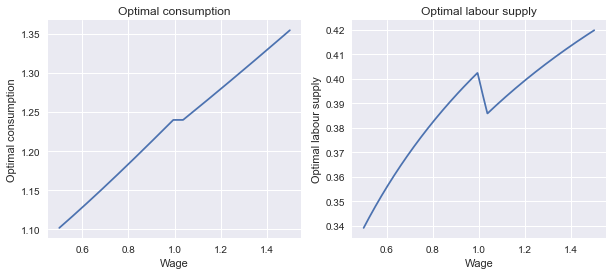

In [7]:
# a. allocate numpy arrays
wages = np.linspace(0.5,1.5,1000)
c_plot = np.empty(len(wages))
l_plot = np.empty(len(wages))

# b. find and save optimal c and l for each wage
for i,w in enumerate(wages):
    result = optimize.minimize_scalar(equilibrium,bounds=(0,1),args=(v,eps,m,w,t_0,t_1,k), method = "bounded")
    l_plot[i] = result.x
    c_plot[i] = optimal_consumption(l_plot[i],m,w,t_0,t_1,k)
    
# c. plot optimal l and c as functions of wage
plt.style.use('seaborn')
fig = plt.figure(figsize=(10,4))

ax_left = fig.add_subplot(1,2,1)
ax_left.plot(wages, c_plot)
ax_left.set_title('Optimal consumption')
ax_left.set_xlabel('Wage')
ax_left.set_ylabel('Optimal consumption')
ax_left.grid(True)

ax_right = fig.add_subplot(1,2,2)
ax_right.plot(wages,l_plot)
ax_right.set_title('Optimal labour supply')
ax_right.set_xlabel('Wage')
ax_right.set_ylabel('Optimal labour supply')
ax_right.grid(True)

plt.show

# Question 3
We define a function to calculate tax revenue:

In [8]:
def tax_rev(t_0, t_1, k,pop_size = 10000):
    """ calculates tax revenue 
    
    Args:

        t_0 (float): standard labor income tax
        t_1 (float): top bracket labor income tax
        k (float): cut-off for the top labor income bracket 
        pop_size (int): default = 10000, population size
        
    Returns:
        (float): total tax revenue
    """
    # a. assign numpy arrays
    wages = np.linspace(0.5,1.5,pop_size)
    l_star = np.zeros(pop_size)
    
    # b. find optimal labor choice for each individual
    for i, w in enumerate(wages):
        res = optimize.minimize_scalar(equilibrium, bounds=(1e-8,1),method='bounded', args = (v,eps,m,w,t_0,t_1,k))
        l_star[i]=res.x
        
    # c. calculate tax for each individual
    tax_i = np.zeros(pop_size)
    for i in range(pop_size):
        tax_i[i] = t_0 * wages[i]*l_star[i] + t_1 * np.fmax(wages[i]*l_star[i]-k,0)
   
    # d. sum tax revenue from each individual 
    tax_rev = np.sum(tax_i)
    
    return tax_rev 

And calculate the tax revenue for a population of 10.000 individuals and an epsilon of 0.3:

In [9]:
eps = 0.3 # Frisch elasticity of labor supply
print(f'Tax revenue for epsilon = {eps:.1f} is: {tax_rev(t_0 = 0.4, t_1 = 0.1, k = 0.4):.2f}') 

Tax revenue for epsilon = 0.3 is: 1630.19


# Question 4
We calculate the tax revenue for a population of 10.000 individuals and an epsilon of 0.1:

In [10]:
eps = 0.1 # Frisch elasticity of labor supply
print(f'Tax revenue for epsilon = {eps:.1f} is: {tax_rev(t_0 = 0.4, t_1 = 0.1, k = 0.4):.2f}') 

Tax revenue for epsilon = 0.1 is: 3196.88


# Question 5
We assume that the income taxes range between 0 and 1. 
We further assume that the cut-off for the top labor income bracket, $\kappa$ ranges from 0 to 1.5.
The reason is that as labor supply, $l$, has a maximum of 1 and wages have a maximum of 1.5, the maximal total wage is 1.5, implying that the maximal top labor income bracket is 1.5. 

We start by creating a function that returns the negative tax revenue. The function prints the values used for each iteration to make it easier to follow the optimization. Then we use the optimize function to minimize this function, maximizing tax revenue. 

In [11]:
def obj(x):
    
    # a. set global i variable to number iterations
    global i 

    # b. unpack parameters
    tau_0 = x[0]
    tau_1 = x[1]
    kappa = x[2]
    
    # c. calculate tax revenue given parameters and print result
    T = tax_rev(tau_0, tau_1, kappa)
    print(f'{i:3d}: t_0 = {x[0]:.8f}, t_1 = {x[1]:.8f}, k = {x[2]:.8f} -> T = {T:.8f}')
    
    # d. number next iteration
    i +=1 
    
    return -T

In [12]:
start = time.time()

# a. initial guess and bounds
x0 = np.array([t_0,t_1,k])
bounds = ((0,1),(0,1),(0,1.5))

# b. call solver
i = 0
eps = 0.3
result = optimize.minimize(obj, x0, method='SLSQP',bounds=bounds)

end = time.time()
print(f'Time elapsed: {end - start:.10f} seconds')

  0: t_0 = 0.40000000, t_1 = 0.10000000, k = 0.40000000 -> T = 1630.18687347
  1: t_0 = 0.40000000, t_1 = 0.10000000, k = 0.40000000 -> T = 1630.18687347
  2: t_0 = 0.40000001, t_1 = 0.10000000, k = 0.40000000 -> T = 1630.18692038
  3: t_0 = 0.40000000, t_1 = 0.10000001, k = 0.40000000 -> T = 1630.18686864
  4: t_0 = 0.40000000, t_1 = 0.10000000, k = 0.40000001 -> T = 1630.18686667
  5: t_0 = 0.99999727, t_1 = 0.00000028, k = 0.00000039 -> T = 105.59773729
  6: t_0 = 0.57395042, t_1 = 0.07100821, k = 0.28403264 -> T = 2139.45484669
  7: t_0 = 0.57395042, t_1 = 0.07100821, k = 0.28403264 -> T = 2139.45484669
  8: t_0 = 0.57395044, t_1 = 0.07100821, k = 0.28403264 -> T = 2139.45487563
  9: t_0 = 0.57395042, t_1 = 0.07100823, k = 0.28403264 -> T = 2139.45483631
 10: t_0 = 0.57395042, t_1 = 0.07100821, k = 0.28403265 -> T = 2139.45483654
 11: t_0 = 0.87976265, t_1 = 0.00000351, k = 0.00000478 -> T = 2348.76277475
 12: t_0 = 0.87976265, t_1 = 0.00000351, k = 0.00000478 -> T = 2348.76277475


In [13]:
# a. unpack results
tau0_best = result.x[0]
tau1_best = result.x[1]
kappa_best = result.x[2]
T_best = -result.fun

# b. print results
print(f'Optimal tau0 is {tau0_best:.4f}, tau1 is {tau1_best:.4f} and kappa is {kappa_best:.4f}')
print(f'We expect the total tax revenue is {T_best:.4f}')

Optimal tau0 is 0.7854, tau1 is 0.0000 and kappa is 0.0000
We expect the total tax revenue is 2466.8603


# Conclusion

In this assignment we have solved the labor supply problem using respectively the scipy optimize function and our own algorithm. The two methods return the same result. We have plotted the optimal consumption and labor supply as functions of wage and calculated tax revenue. Lastly, we have maximized tax revenue with respect to the labor income taxes and the cutoff for the top labor income bracket. 